In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [4]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [7]:
output_emb_file = '../../models/graphsage_link_pred/full_cos_graphsage_linkpred_21_h.npy'

In [8]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [9]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [10]:
index.train(embeddings)
index.add(embeddings)

In [11]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f2b8c0cda80> >

In [12]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [13]:
distances, indices = index.search(embeddings, 2)

In [14]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(10607)

In [15]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [16]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [17]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [18]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

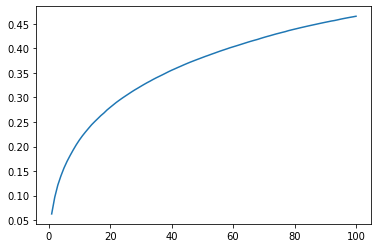

In [19]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [20]:
percentages

tensor([0.0626, 0.0966, 0.1214, 0.1399, 0.1561, 0.1697, 0.1817, 0.1930, 0.2035,
        0.2131, 0.2218, 0.2296, 0.2371, 0.2444, 0.2508, 0.2568, 0.2630, 0.2683,
        0.2744, 0.2796, 0.2847, 0.2898, 0.2943, 0.2988, 0.3030, 0.3071, 0.3113,
        0.3152, 0.3189, 0.3227, 0.3264, 0.3299, 0.3332, 0.3367, 0.3400, 0.3430,
        0.3460, 0.3492, 0.3524, 0.3554, 0.3581, 0.3609, 0.3636, 0.3665, 0.3691,
        0.3717, 0.3741, 0.3766, 0.3789, 0.3813, 0.3837, 0.3858, 0.3882, 0.3904,
        0.3927, 0.3949, 0.3970, 0.3990, 0.4012, 0.4031, 0.4050, 0.4070, 0.4090,
        0.4110, 0.4130, 0.4149, 0.4166, 0.4183, 0.4204, 0.4223, 0.4241, 0.4258,
        0.4276, 0.4294, 0.4310, 0.4326, 0.4341, 0.4361, 0.4376, 0.4391, 0.4406,
        0.4422, 0.4436, 0.4450, 0.4464, 0.4478, 0.4491, 0.4505, 0.4518, 0.4532,
        0.4544, 0.4557, 0.4568, 0.4581, 0.4596, 0.4608, 0.4620, 0.4632, 0.4643,
        0.4655])

In [21]:
percentages.max()

tensor(0.4655)

### Percentage of same class neighbors by neighborhood size

In [22]:
y = dataset[0][1][:, 0]

In [23]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [24]:
label_transform = np.vectorize(label_dict.get)

In [25]:
ind_labels = label_transform(indices)

In [26]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [27]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [28]:
perc_same_class = n_same_class / n_total

In [29]:
perc_same_class

array([0.47699049, 0.46026998, 0.44917318, 0.44212043, 0.43652469,
       0.43206982, 0.42848876, 0.42547005, 0.42268781, 0.42046379,
       0.41841813, 0.41645802, 0.41468045, 0.41311716, 0.41165248,
       0.41020924, 0.40891911, 0.40772344, 0.40655387, 0.40549093,
       0.40446257, 0.40355669, 0.40267027, 0.40178981, 0.40095758,
       0.40019255, 0.39949382, 0.39876949, 0.39805255, 0.39738834,
       0.39678088, 0.39618334, 0.39558962, 0.39498672, 0.39437929,
       0.39381315, 0.39327857, 0.39277089, 0.39221307, 0.39174353,
       0.39128624, 0.39080784, 0.39035114, 0.38989372, 0.38946661,
       0.38898464, 0.38857118, 0.38817051, 0.38773365, 0.3873386 ,
       0.38693866, 0.38660248, 0.38622394, 0.38588064, 0.38549238,
       0.38513771, 0.38480978, 0.38445844, 0.384115  , 0.38377445,
       0.38345494, 0.38311364, 0.38279414, 0.3824921 , 0.38221298,
       0.38192236, 0.38164095, 0.3813653 , 0.38108514, 0.38081223,
       0.38052921, 0.38027012, 0.38003795, 0.37978533, 0.37952

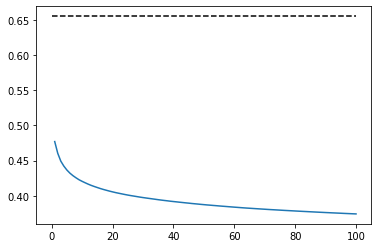

In [30]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [31]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [32]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [33]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [34]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2a881c0f90> >

In [35]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [36]:
distances, indices = index_cos.search(emb_norm, 2)

In [37]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(10540)

In [38]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [39]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9959729538682041

In [40]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [41]:
indices

array([[     0, 126842, 108953, ..., 151557,  27644, 123301],
       [     1, 154949, 113212, ...,  86914,  80918,   2859],
       [     2, 113232,  68589, ...,  56159,   3232,   6491],
       ...,
       [169340, 100443,  41371, ...,  33456,  38817, 125130],
       [169341, 140151, 113080, ...,  45512,  72240,  80000],
       [169342,  82748,  82093, ..., 101449,  27365,  63366]])

In [42]:
sum(emb_norm[0] * emb_norm[411])

0.9919459077364081

In [43]:
distances

array([[1.0000001 , 0.9993862 , 0.99935275, ..., 0.99707514, 0.9970736 ,
        0.99705595],
       [0.9999999 , 0.9999172 , 0.9980963 , ..., 0.9864138 , 0.98600596,
        0.9859197 ],
       [1.        , 0.9999743 , 0.9999547 , ..., 0.99941546, 0.9994118 ,
        0.9994099 ],
       ...,
       [1.0000001 , 0.9864154 , 0.98142916, ..., 0.95761186, 0.95753187,
        0.9574651 ],
       [0.99999994, 0.9997052 , 0.9994644 , ..., 0.99727124, 0.99726427,
        0.99724877],
       [1.        , 0.971394  , 0.9657069 , ..., 0.92447364, 0.9244446 ,
        0.92428595]], dtype=float32)

In [44]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [45]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

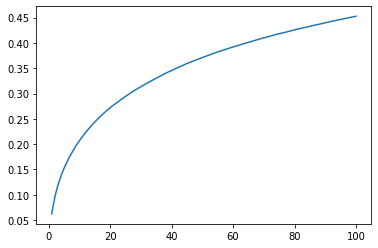

In [46]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [47]:
percentages

tensor([0.0623, 0.0951, 0.1186, 0.1367, 0.1519, 0.1652, 0.1771, 0.1877, 0.1977,
        0.2067, 0.2149, 0.2230, 0.2300, 0.2371, 0.2436, 0.2497, 0.2559, 0.2614,
        0.2667, 0.2717, 0.2767, 0.2810, 0.2856, 0.2900, 0.2941, 0.2982, 0.3023,
        0.3062, 0.3099, 0.3134, 0.3168, 0.3203, 0.3236, 0.3270, 0.3302, 0.3334,
        0.3366, 0.3398, 0.3427, 0.3454, 0.3483, 0.3510, 0.3536, 0.3564, 0.3592,
        0.3616, 0.3641, 0.3664, 0.3687, 0.3708, 0.3732, 0.3756, 0.3777, 0.3799,
        0.3821, 0.3841, 0.3859, 0.3880, 0.3900, 0.3918, 0.3938, 0.3956, 0.3975,
        0.3993, 0.4010, 0.4029, 0.4046, 0.4064, 0.4083, 0.4099, 0.4115, 0.4132,
        0.4150, 0.4166, 0.4181, 0.4194, 0.4209, 0.4225, 0.4241, 0.4256, 0.4272,
        0.4286, 0.4299, 0.4313, 0.4327, 0.4342, 0.4355, 0.4368, 0.4382, 0.4396,
        0.4410, 0.4424, 0.4436, 0.4450, 0.4463, 0.4475, 0.4489, 0.4500, 0.4512,
        0.4526])

### Percentage of same class neighbors by neighborhood size

In [48]:
ind_labels = label_transform(indices)

In [49]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [50]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [51]:
perc_same_class = n_same_class / n_total

In [52]:
perc_same_class

array([0.47498863, 0.4589177 , 0.44922239, 0.4420289 , 0.43651524,
       0.43221647, 0.42871147, 0.42575276, 0.42318647, 0.42102478,
       0.41891148, 0.41708003, 0.41548809, 0.41391057, 0.41240402,
       0.41106659, 0.40987366, 0.40873684, 0.40768176, 0.40668702,
       0.40571643, 0.40476644, 0.40389084, 0.40307886, 0.40234813,
       0.40154325, 0.40082401, 0.40014982, 0.39949851, 0.39887605,
       0.39827298, 0.39763767, 0.39706287, 0.39649549, 0.39595293,
       0.39543494, 0.39495899, 0.39447639, 0.39402066, 0.39355716,
       0.39312232, 0.3927034 , 0.39227773, 0.39183156, 0.39141204,
       0.39101371, 0.39062228, 0.39025676, 0.38988808, 0.38954843,
       0.38916398, 0.38882248, 0.38850735, 0.38817043, 0.38786422,
       0.38752698, 0.38721795, 0.38692924, 0.3866252 , 0.38635019,
       0.38604654, 0.38578535, 0.38550724, 0.38523505, 0.38494871,
       0.38468491, 0.38442617, 0.38417443, 0.3839032 , 0.38365659,
       0.38340661, 0.38316284, 0.3829399 , 0.3827123 , 0.38247

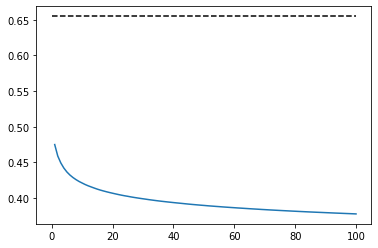

In [53]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [54]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [55]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [56]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7f2a88114270> >

In [57]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [58]:
distances, indices = index_ip.search(embeddings, 2)

In [59]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(20256)

In [60]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [61]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

1251.5600211939309

In [62]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [63]:
indices

array([[139064,  57211, 151168, ..., 104544,  73319, 120526],
       [ 37280,  33146, 115598, ...,  80341,  12592,  54467],
       [ 32057, 139064,  19317, ...,  44828,  11865, 158916],
       ...,
       [ 39702,  29980, 110395, ...,  33620, 117734,  49572],
       [139064,  57211, 151168, ...,  81423, 104544,  38040],
       [153757,  53600, 145681, ...,  71712, 135705,  87575]])

In [64]:
sum(embeddings[0] * embeddings[411])

2502.1200423878618

In [65]:
distances

array([[ 18889.582 ,  18737.445 ,  18640.494 , ...,  14025.831 ,
         14024.546 ,  14018.808 ],
       [187783.66  , 184779.9   , 183340.55  , ..., 165111.98  ,
        164934.25  , 164902.22  ],
       [185391.52  , 181483.88  , 180946.97  , ..., 134343.72  ,
        134259.22  , 134133.97  ],
       ...,
       [  6244.899 ,   5916.0986,   5808.402 , ...,   5150.2114,
          5146.9126,   5138.728 ],
       [ 28449.578 ,  28196.271 ,  28033.209 , ...,  21105.377 ,
         21102.34  ,  21101.902 ],
       [ 20577.658 ,  19580.475 ,  19507.379 , ...,  17094.451 ,
         17054.824 ,  17018.133 ]], dtype=float32)

In [66]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [67]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

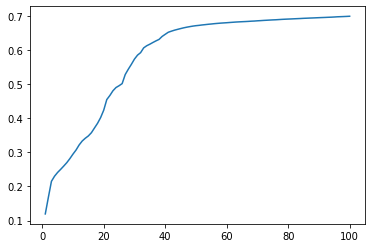

In [68]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [69]:
percentages

tensor([0.1196, 0.1682, 0.2152, 0.2301, 0.2412, 0.2503, 0.2599, 0.2700, 0.2818,
        0.2949, 0.3069, 0.3217, 0.3333, 0.3414, 0.3482, 0.3577, 0.3716, 0.3853,
        0.4021, 0.4237, 0.4549, 0.4668, 0.4806, 0.4902, 0.4955, 0.5017, 0.5283,
        0.5439, 0.5582, 0.5736, 0.5851, 0.5924, 0.6064, 0.6127, 0.6172, 0.6222,
        0.6270, 0.6313, 0.6400, 0.6462, 0.6522, 0.6554, 0.6583, 0.6607, 0.6630,
        0.6652, 0.6671, 0.6687, 0.6703, 0.6715, 0.6725, 0.6736, 0.6746, 0.6756,
        0.6765, 0.6774, 0.6782, 0.6790, 0.6796, 0.6802, 0.6809, 0.6815, 0.6822,
        0.6827, 0.6832, 0.6836, 0.6841, 0.6847, 0.6851, 0.6858, 0.6863, 0.6870,
        0.6875, 0.6880, 0.6885, 0.6889, 0.6895, 0.6900, 0.6905, 0.6909, 0.6913,
        0.6917, 0.6922, 0.6926, 0.6931, 0.6934, 0.6938, 0.6942, 0.6946, 0.6950,
        0.6954, 0.6957, 0.6961, 0.6965, 0.6970, 0.6976, 0.6979, 0.6983, 0.6987,
        0.6992])

### Percentage of same class neighbors by neighborhood size

In [70]:
ind_labels = label_transform(indices)

In [71]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [72]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [73]:
perc_same_class = n_same_class / n_total

In [74]:
perc_same_class

array([0.50790408, 0.52137378, 0.5138998 , 0.51212332, 0.50892331,
       0.50447415, 0.50807364, 0.50967489, 0.51148327, 0.5110846 ,
       0.51213701, 0.5127975 , 0.5111224 , 0.50826134, 0.5055857 ,
       0.5021517 , 0.50019852, 0.49748243, 0.49603654, 0.49503788,
       0.49463937, 0.49429721, 0.4928179 , 0.49259073, 0.49241362,
       0.49120106, 0.49037271, 0.48939895, 0.48833962, 0.48698401,
       0.48543679, 0.48428209, 0.48275143, 0.48142493, 0.48015448,
       0.47905894, 0.47834102, 0.47768574, 0.47713009, 0.47665773,
       0.47621878, 0.47559504, 0.47503574, 0.47416634, 0.47314819,
       0.47204837, 0.47115052, 0.47018219, 0.46918939, 0.46830043,
       0.46758459, 0.46679816, 0.46602736, 0.4654298 , 0.46481412,
       0.46416023, 0.46376497, 0.46343811, 0.46301284, 0.46262654,
       0.46233297, 0.46207954, 0.46162419, 0.46120457, 0.46107559,
       0.460807  , 0.46023936, 0.45982093, 0.45934488, 0.45883368,
       0.45831017, 0.45772641, 0.45717224, 0.45659864, 0.45614

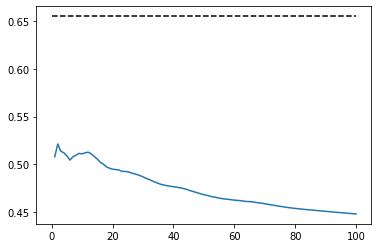

In [75]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [76]:
pca = PCA(n_components=2)

In [77]:
pca.fit(embeddings)

PCA(n_components=2)

In [78]:
emb_2d = pca.transform(embeddings)

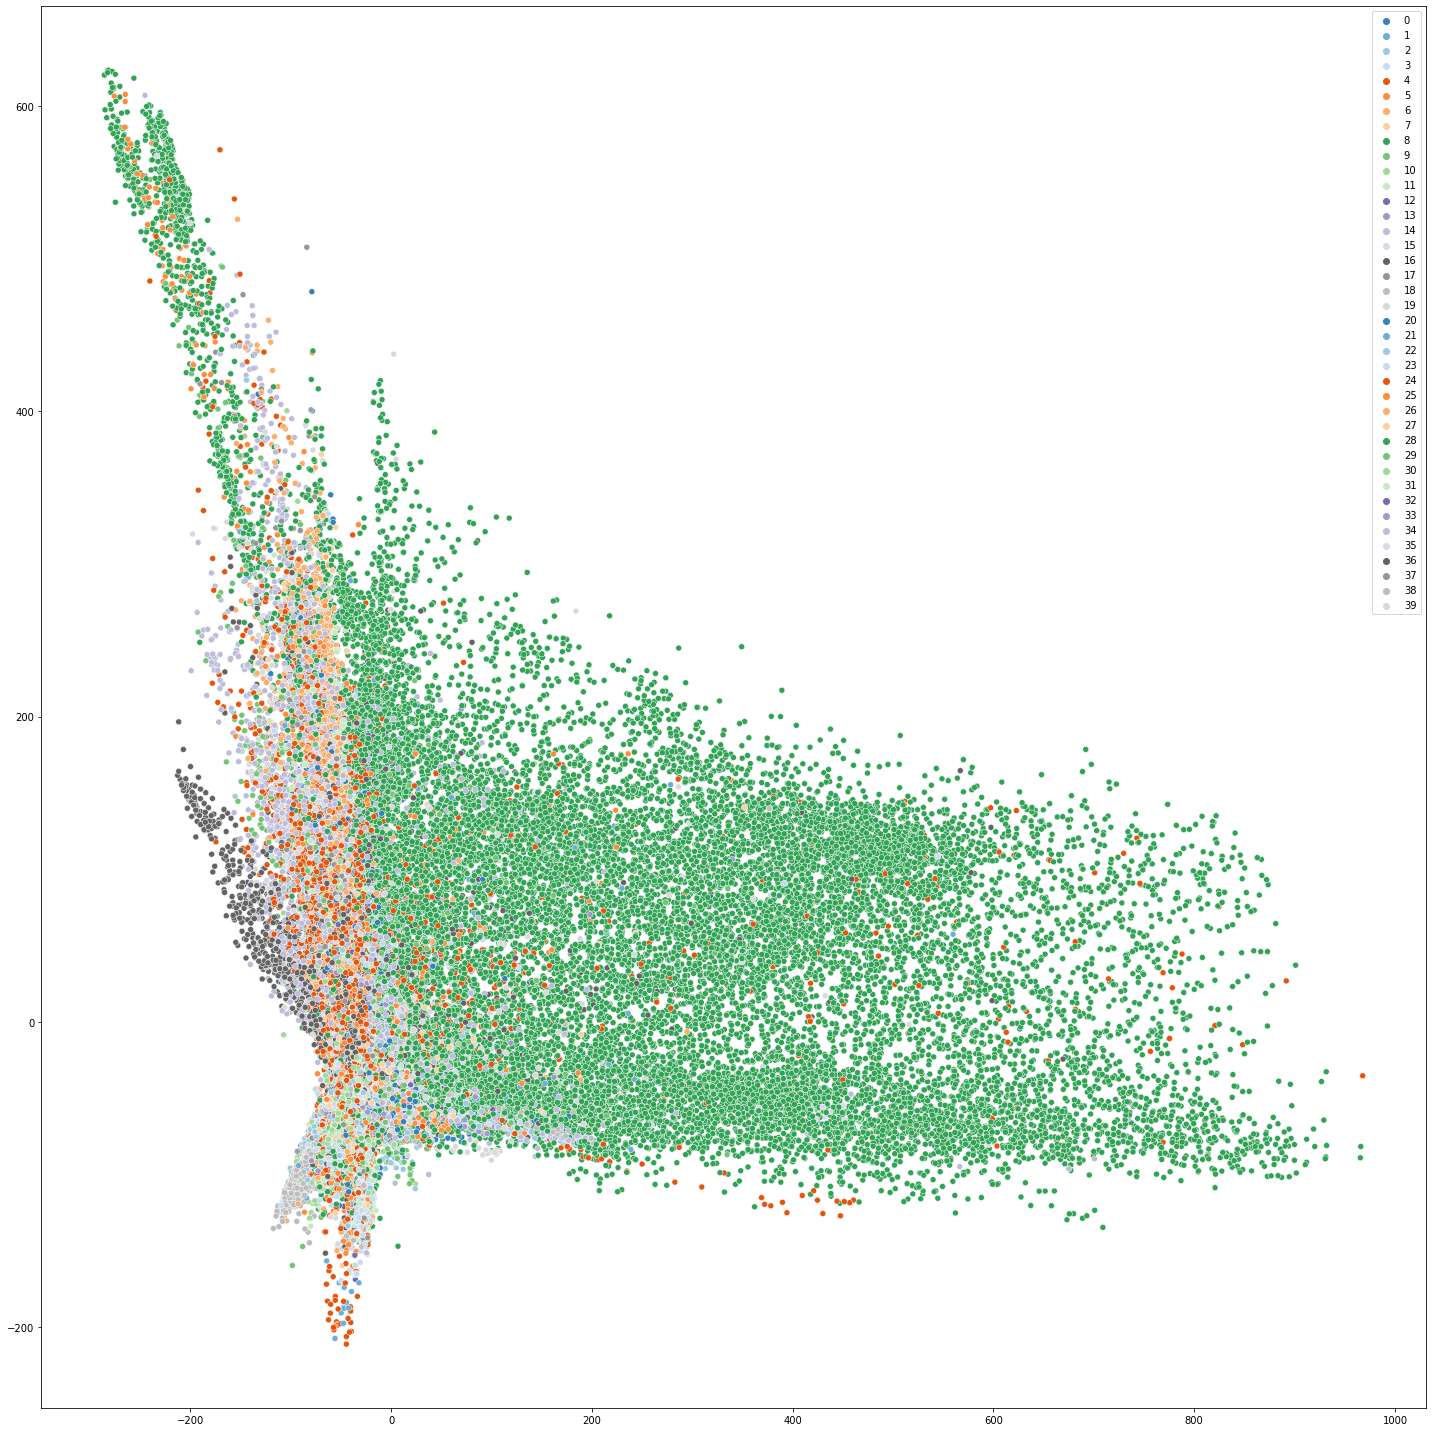

In [79]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [80]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

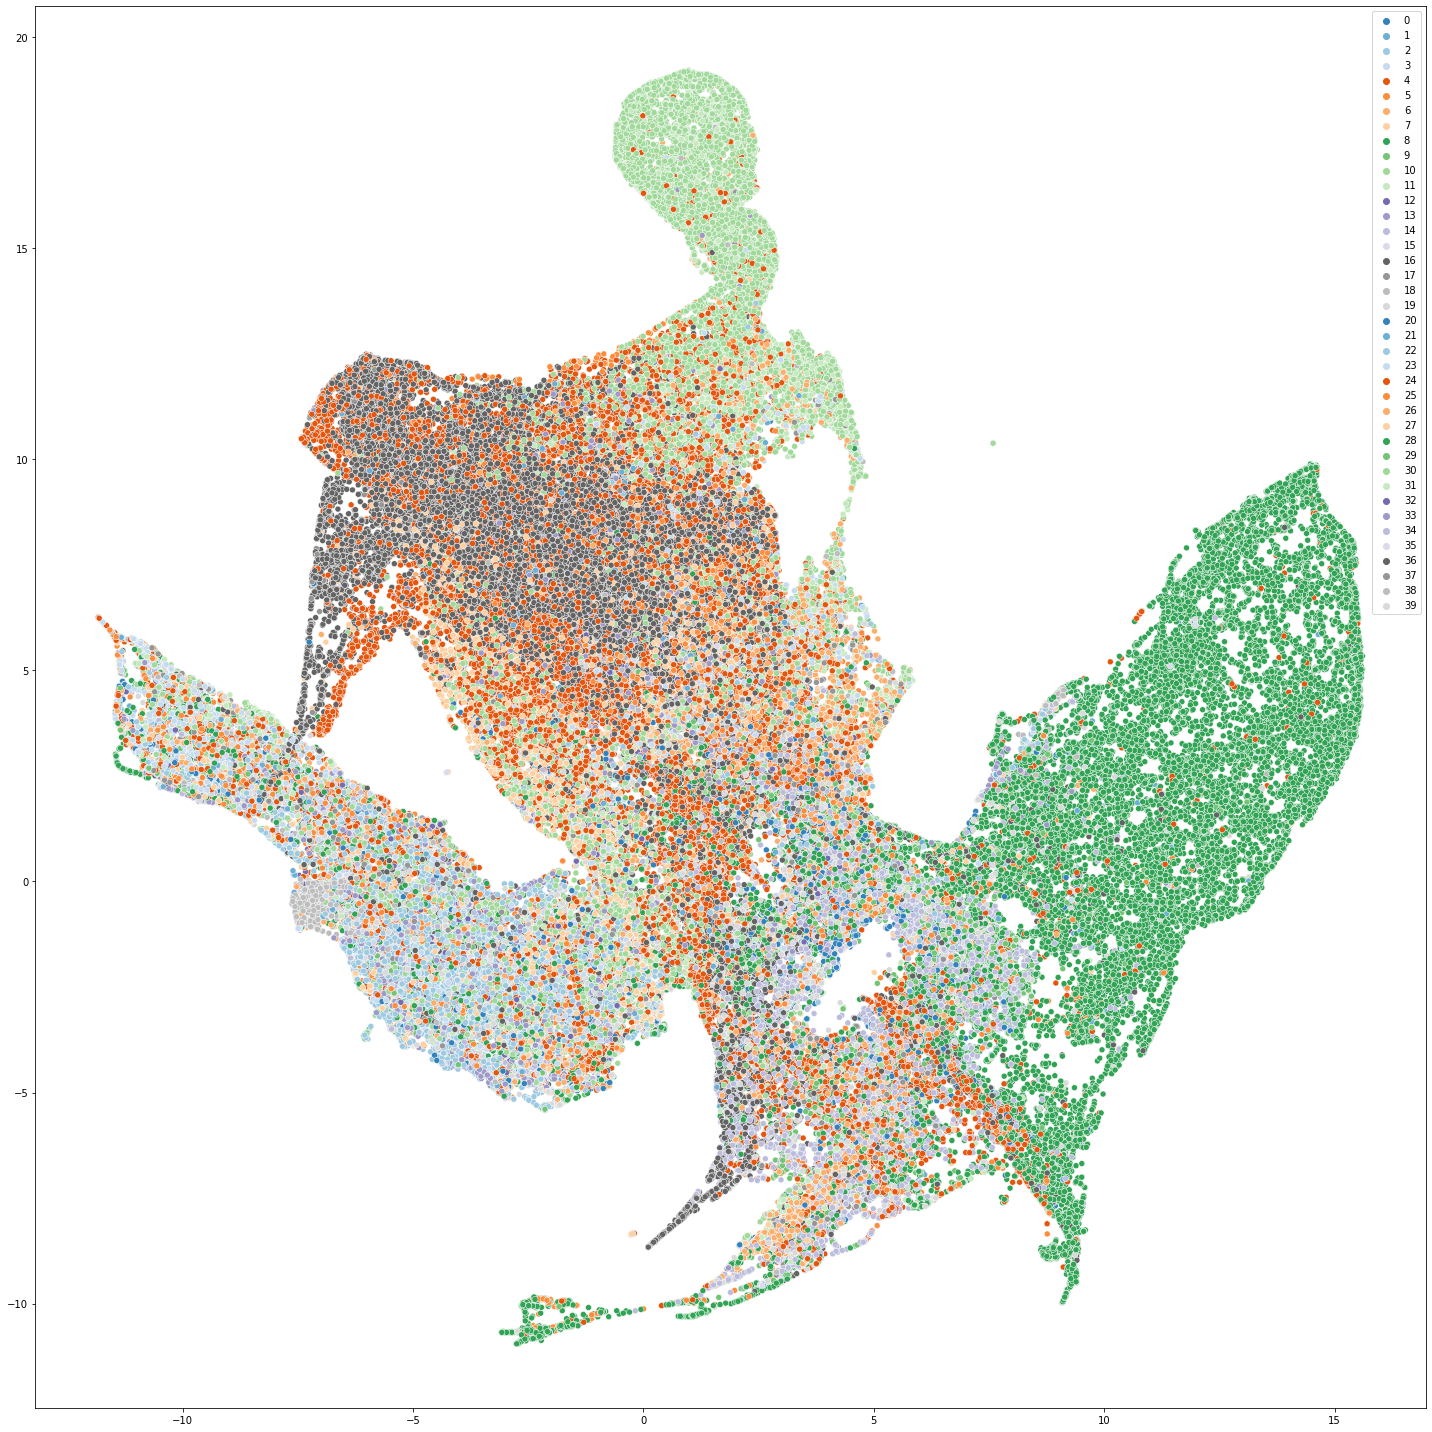

In [81]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [ ]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

In [ ]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()